In [1]:
# Get datasets from: https://drive.google.com/open?id=16w02wuMOqoLm6-YlM-rhAC1uZthO-2A3
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# authenticate user credentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# download datasets from GDrive
#downloaded = drive.CreateFile({'id': '1pghUuYyaYsuwDCA7Ow1Y601kGl6qPboL'})
#downloaded.GetContentFile('large_10_1000.zip')
#downloaded = drive.CreateFile({'id': '19wcJs9TdIwhT85TGdsaw1GV1ypbLnOpK'})
#downloaded.GetContentFile('small_10_100.zip')
downloaded = drive.CreateFile({'id': '1f-o1ygRlTZtvhbC9naP721khFJicbp-n'})
downloaded.GetContentFile('large_95_100.zip')

# unzip the datasets
#!unzip -o small_10_100.zip
#!unzip -o large_10_1000.zip
!unzip -o large_95_100.zip

Streaming output truncated to the last 5000 lines.
  inflating: undefended/5-0          
  inflating: undefended/50-0         
  inflating: undefended/50-1         
  inflating: undefended/50-10        
  inflating: undefended/50-11        
  inflating: undefended/50-12        
  inflating: undefended/50-13        
  inflating: undefended/50-14        
  inflating: undefended/50-15        
  inflating: undefended/50-16        
  inflating: undefended/50-17        
  inflating: undefended/50-18        
  inflating: undefended/50-19        
  inflating: undefended/50-2         
  inflating: undefended/50-20        
  inflating: undefended/50-21        
  inflating: undefended/50-22        
  inflating: undefended/50-23        
  inflating: undefended/50-24        
  inflating: undefended/50-25        
  inflating: undefended/50-26        
  inflating: undefended/50-27        
  inflating: undefended/50-28        
  inflating: undefended/50-29        
  inflating: undefended/50-3         

In [2]:
import warnings
import random
import pandas as pd
import numpy as np
from numpy import array

import keras
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform
from keras import backend as K
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import graphviz

import sklearn
print(sklearn.__version__)

1.0.2


In [3]:
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l2

import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)


In [4]:

# Global Definitions
data_path="undefended/"  # trace data path

num_sites=95               # number of sites (max 95)
num_instances=100          # number of instances per site (max 100)
file_ext=""                # trace file extension
max_length =2000           # maximum number of packet directions to use
INPUT_SHAPE = (max_length,1)

In [5]:

def get_data():
    """

    :return: a numpy ndarray of dimension (m x (n+1)) containing direction data
        loaded from the files, where `m` is the number of data samples and `n`
        is length of direction packets (restricted to 500 to consume less
        computation time and memory). The last column in the data contains the
        class labels of the `m` samples, which are the website numbers.

    This function loads the data from the files and creates a numpy data matrix
    with each row as a data sample and the columns containing packet direction.
    The last column of the data is the label, which is the website to which the
    instance belongs.
    """

    # read data from files
    print("loading data...")
    data = []
    for site in range(0, num_sites):
        for instance in range(0, num_instances):
            file_name = str(site) + "-" + str(instance)
            # Directory of the raw data
            with open(data_path + file_name + file_ext, "r") as file_pt:
                directions = []
                for line in file_pt:
                    x = line.strip().split('\t')
                    directions.append(1 if float(x[1]) > 0 else -1)
                if len(directions) < max_length:
                    zend = max_length - len(directions)
                    directions.extend([0] * zend)
                elif len(directions) > max_length:
                    directions = directions[:max_length]
                data.append(directions + [site])
    print("done")
    return np.array(data)


def split_data(X, Y, fraction=0.80, balance_dist=False):
    """
    :param X: a numpy ndarray of dimension (m x n) containing data samples
    :param Y: a numpy ndarray of dimension (m x 1) containing labels for X
    :param fraction: a value between 0 and 1, which will be the fraction of
        data split into training and test sets. value of `fraction` will be the
        training data and the rest being test data.
    :param balance_dist: boolean value. The split is performed with ensured
        class balance if the value is true.
    :return: X_train, Y_train, X_test, Y_test

    This function splits the data into training and test datasets.
    """
    X, Y = shuffle(X, Y)
    m, n = X.shape
    split_index = int(round(m*fraction))
    if balance_dist:
        X_train = np.zeros(shape=(split_index, n))
        X_test = np.zeros(shape=(m-split_index, n))
        Y_train = np.zeros(shape=(split_index,))
        Y_test = np.zeros(shape=(m-split_index,))
        labels = np.unique(Y)
        ind1 = 0
        ind2 = 0
        for i in np.arange(labels.size):
            indices = np.where(Y == labels[i])[0]
            split = int(round(len(indices)*fraction))

            X_train[ind1:ind1 + split, :] = X[indices[:split], :]
            X_test[ind2:ind2+(indices.size-split), :] = X[indices[split:], :]

            Y_train[ind1:ind1 + split] = Y[indices[:split]]
            Y_test[ind2:ind2+(indices.size-split)] = Y[indices[split:]]

            ind1 += split
            ind2 += indices.size-split
        X_train, Y_train = shuffle(X_train, Y_train)
        X_test, Y_test = shuffle(X_test, Y_test)
        return X_train, Y_train, X_test, Y_test
    return X[:split_index, :], Y[:split_index], \
        X[split_index:, :], Y[split_index:]


In [6]:
# Load the data and create X and Y matrices
data = get_data()
num_features = data.shape[1] - 1
X = data[:, :num_features]
Y = data[:, -1]

# split the data into training and test set
X_train, Y_train, X_test, Y_test = split_data(X, Y, 0.85, balance_dist=True)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)


loading data...
done


In [7]:
filter_num = ['None',32,64,128,256]
kernel_size = ['None',8,8,8,8]
conv_stride_size = ['None',1,1,1,1]
pool_stride_size = ['None',4,4,4,4]
pool_size = ['None',8,8,8,8]

In [8]:
class CNN3:
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        model.add(Conv1D(filters=filter_num[1], 
                         kernel_size=kernel_size[1], 
                         input_shape=input_shape,
                         strides=conv_stride_size[1], 
                         padding='same',
                         name='convolution1'))
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='activation1'))
        model.add(Conv1D(filters=filter_num[1], 
                         kernel_size=kernel_size[1],
                         strides=conv_stride_size[1],
                         padding='same',
                         name='convolution2'))
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='activation2'))
        model.add(MaxPooling1D(pool_size=pool_size[1], 
                               strides=pool_stride_size[1],
                               padding='same', 
                               name='pool1'))
        model.add(Dropout(0.1, name='dropout1'))

        model.add(Conv1D(filters=filter_num[2], 
                         kernel_size=kernel_size[2],
                         strides=conv_stride_size[2], 
                         padding='same',
                         name='convolution3'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='activation3'))
        model.add(Conv1D(filters=filter_num[2], 
                         kernel_size=kernel_size[2],
                         strides=conv_stride_size[2], 
                         padding='same',
                         name='convolution4'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='activatio4'))
        model.add(MaxPooling1D(pool_size=pool_size[2], 
                               strides=pool_stride_size[3],
                               padding='same', 
                               name='pool2'))
        model.add(Dropout(0.1, name='dropout2'))

        model.add(Conv1D(filters=filter_num[3], 
                         kernel_size=kernel_size[3],
                         strides=conv_stride_size[3], 
                         padding='same',
                         name='convolution5'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='activation5'))
        model.add(Conv1D(filters=filter_num[3], 
                         kernel_size=kernel_size[3],
                         strides=conv_stride_size[3], 
                         padding='same',
                         name='convolution6'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='activation6'))
        model.add(MaxPooling1D(pool_size=pool_size[3], 
                               strides=pool_stride_size[3],
                               padding='same', 
                               name='pool3'))
        model.add(Dropout(0.1, name='dropout3'))

        model.add(Conv1D(filters=filter_num[4], 
                         kernel_size=kernel_size[4],
                         strides=conv_stride_size[4], 
                         padding='same',
                         name='convolution7'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='activation7'))
        model.add(Conv1D(filters=filter_num[4], 
                         kernel_size=kernel_size[4],
                         strides=conv_stride_size[4], 
                         padding='same',
                         name='convolutio8'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='activation8'))
        model.add(MaxPooling1D(pool_size=pool_size[4], 
                               strides=pool_stride_size[4],
                               padding='same', 
                               name='pool4'))
        model.add(Dropout(0.1, name='dropout4'))

        model.add(Flatten(name='flatten'))

        model.add(Dense(512, kernel_initializer=glorot_uniform(seed=0), 
                        name='dense1'))
        model.add(BatchNormalization())
        model.add(Activation('relu', 
                             name='activationf1'))
        model.add(Dropout(0.7, name='dropoutf1'))

        model.add(Dense(512, kernel_initializer=glorot_uniform(seed=0), 
                        name='dense2'))
        model.add(BatchNormalization())
        model.add(Activation('relu', 
                             name='activationf2'))
        model.add(Dropout(0.5, name='dropoutf2'))

        model.add(Dense(classes, kernel_initializer=glorot_uniform(seed=0), 
                        name='dense3'))
        model.add(Activation('softmax', name="softmax"))

        return model

In [9]:
%%time
# Building and training model
print ("Building and training DL model")
model = CNN3.build(input_shape=INPUT_SHAPE, classes=num_sites)
# Give a summary
model.summary()

Building and training DL model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution1 (Conv1D)       (None, 2000, 32)          288       
                                                                 
 batch_normalization (BatchN  (None, 2000, 32)         128       
 ormalization)                                                   
                                                                 
 activation1 (ELU)           (None, 2000, 32)          0         
                                                                 
 convolution2 (Conv1D)       (None, 2000, 32)          8224      
                                                                 
 batch_normalization_1 (Batc  (None, 2000, 32)         128       
 hNormalization)                                                 
                                                                 
 activation2 (ELU)       

In [10]:
OPTIMIZER1 = Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
OPTIMIZER2 = Adamax(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
OPTIMIZER3 = Adamax(learning_rate=0.1,beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
NB_EPOCH = 20
BATCH_SIZE = 100

In [11]:
model1 = model
model1.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER1, metrics=["accuracy"])
print ("Model-1 compiled")
model2 = model
model2.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER2, metrics=["accuracy"])
print ("Model-2 compiled")
model3 = model
model3.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER3, metrics=["accuracy"])
print ("Model-3 compiled")

Model-1 compiled
Model-2 compiled
Model-3 compiled


In [12]:
%%time
# Start training
model_history1 = model1.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,verbose=0, 
                    validation_data=(X_test, Y_test))


# Start evaluating model with testing data
score_test1 = model1.evaluate(X_test, Y_test, verbose=0)
print("Testing accuracy:", score_test1[1])
print("Testing loss:", score_test1[0])

Testing accuracy: 0.8259649276733398
Testing loss: 0.6505122184753418
CPU times: user 1min 27s, sys: 3.57 s, total: 1min 30s
Wall time: 1min 33s


In [13]:
%%time
# Start training
model_history2 = model2.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,verbose=0, 
                    validation_data=(X_test, Y_test))

# Start evaluating model with testing data
score_test2 = model2.evaluate(X_test, Y_test, verbose=0)
print("Testing accuracy:", score_test2[1])
print("Testing loss:", score_test2[0])

Testing accuracy: 0.8701754212379456
Testing loss: 0.5941561460494995
CPU times: user 1min 19s, sys: 2.65 s, total: 1min 21s
Wall time: 1min 27s


In [14]:
%%time
# Start training
model_history3 = model3.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,verbose=0, 
                    validation_data=(X_test, Y_test))


# Start evaluating model with testing data
score_test3 = model3.evaluate(X_test, Y_test, verbose=0)
print("Testing accuracy:", score_test3[1])
print("Testing loss:", score_test3[0])

Testing accuracy: 0.9228070378303528
Testing loss: 0.42133545875549316
CPU times: user 1min 20s, sys: 2.46 s, total: 1min 23s
Wall time: 1min 24s


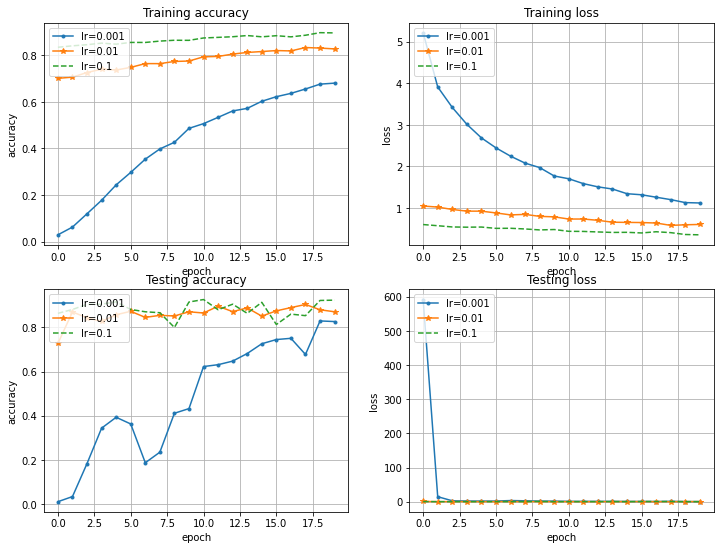

CPU times: user 689 ms, sys: 39.8 ms, total: 729 ms
Wall time: 707 ms


In [15]:
%%time

plt.subplots(figsize=(12, 9))

plt.subplot(2, 2, 1) # (rows, columns, panel number)
# summarize history for accuracy
plt.plot(model_history1.history['accuracy'], '.-')
plt.plot(model_history2.history['accuracy'], '*-')
plt.plot(model_history3.history['accuracy'], '--')
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['lr=0.001', 'lr=0.01', 'lr=0.1'], loc='upper left')
#plt.show()

plt.subplot(2, 2, 2) # (rows, columns, panel number)
# summarize history for loss
plt.plot(model_history1.history['loss'], '.-')
plt.plot(model_history2.history['loss'], '*-')
plt.plot(model_history3.history['loss'], '--')
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['lr=0.001', 'lr=0.01', 'lr=0.1'], loc='upper left')
#plt.show()

plt.subplot(2, 2, 3) # (rows, columns, panel number)
# summarize history for accuracy
plt.plot(model_history1.history['val_accuracy'], '.-')
plt.plot(model_history2.history['val_accuracy'], '*-')
plt.plot(model_history3.history['val_accuracy'], '--')
plt.title('Testing accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['lr=0.001', 'lr=0.01', 'lr=0.1'], loc='upper left')
#plt.show()

plt.subplot(2, 2, 4) # (rows, columns, panel number)
# summarize history for loss
plt.plot(model_history1.history['val_loss'], '.-')
plt.plot(model_history2.history['val_loss'], '*-')
plt.plot(model_history3.history['val_loss'], '--')
plt.title('Testing loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['lr=0.001', 'lr=0.01', 'lr=0.1'], loc='upper left')
plt.show()


In [16]:
%%time
# Start training
model_historyA = model3.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE, epochs=20,verbose=0, 
                    validation_data=(X_test, Y_test))


# Start evaluating model with testing data
score_testA = model3.evaluate(X_test, Y_test, verbose=0)
print("Testing accuracy:", score_testA[1])
print("Testing loss:", score_testA[0])

Testing accuracy: 0.9368420839309692
Testing loss: 0.3597758114337921
CPU times: user 1min 19s, sys: 2.45 s, total: 1min 21s
Wall time: 1min 26s


In [17]:
%%time
# Start training
model_historyB = model3.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE, epochs=30,verbose=0, 
                    validation_data=(X_test, Y_test))


# Start evaluating model with testing data
score_testB = model3.evaluate(X_test, Y_test, verbose=0)
print("Testing accuracy:", score_testB[1])
print("Testing loss:", score_testB[0])

Testing accuracy: 0.9298245906829834
Testing loss: 0.40311333537101746
CPU times: user 2min, sys: 3.8 s, total: 2min 4s
Wall time: 2min 7s


In [18]:
%%time
# Start training
model_historyC = model3.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE, epochs=50,verbose=0, 
                    validation_data=(X_test, Y_test))


# Start evaluating model with testing data
score_testC = model3.evaluate(X_test, Y_test, verbose=0)
print("Testing accuracy:", score_testC[1])
print("Testing loss:", score_testC[0])

Testing accuracy: 0.9487719535827637
Testing loss: 0.41735759377479553
CPU times: user 3min 22s, sys: 6.17 s, total: 3min 29s
Wall time: 4min 22s


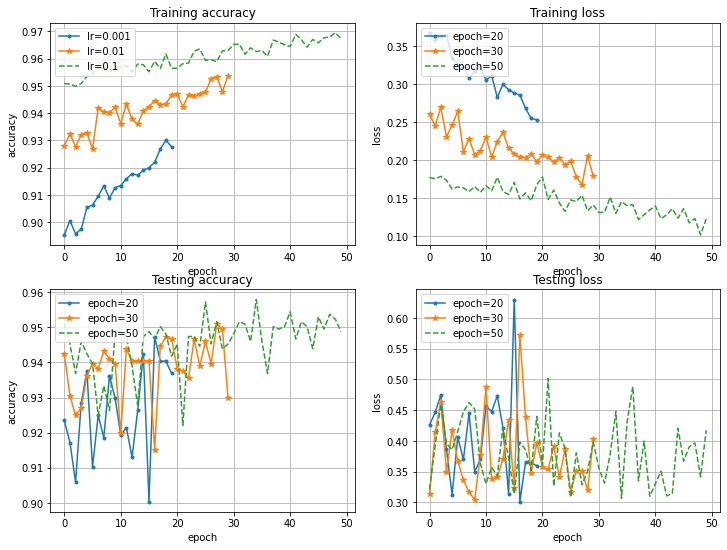

CPU times: user 677 ms, sys: 26.4 ms, total: 704 ms
Wall time: 697 ms


In [19]:
%%time

plt.subplots(figsize=(12, 9))

plt.subplot(2, 2, 1) # (rows, columns, panel number)
# summarize history for accuracy
plt.plot(model_historyA.history['accuracy'], '.-')
plt.plot(model_historyB.history['accuracy'], '*-')
plt.plot(model_historyC.history['accuracy'], '--')
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['lr=0.001', 'lr=0.01', 'lr=0.1'], loc='upper left')
#plt.show()

plt.subplot(2, 2, 2) # (rows, columns, panel number)
# summarize history for loss
plt.plot(model_historyA.history['loss'], '.-')
plt.plot(model_historyB.history['loss'], '*-')
plt.plot(model_historyC.history['loss'], '--')
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['epoch=20', 'epoch=30', 'epoch=50'], loc='upper left')
#plt.show()

plt.subplot(2, 2, 3) # (rows, columns, panel number)
# summarize history for accuracy
plt.plot(model_historyA.history['val_accuracy'], '.-')
plt.plot(model_historyB.history['val_accuracy'], '*-')
plt.plot(model_historyC.history['val_accuracy'], '--')
plt.title('Testing accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['epoch=20', 'epoch=30', 'epoch=50'], loc='upper left')
#plt.show()

plt.subplot(2, 2, 4) # (rows, columns, panel number)
# summarize history for loss
plt.plot(model_historyA.history['val_loss'], '.-')
plt.plot(model_historyB.history['val_loss'], '*-')
plt.plot(model_historyC.history['val_loss'], '--')
plt.title('Testing loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['epoch=20', 'epoch=30', 'epoch=50'], loc='upper left')
plt.show()

In [20]:
%%time
# Start training
model_historyD = model3.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE, epochs=60,verbose=0, 
                    validation_data=(X_test, Y_test))


# Start evaluating model with testing data
score_testD = model3.evaluate(X_test, Y_test, verbose=0)
print("Testing accuracy:", score_testD[1])
print("Testing loss:", score_testD[0])

Testing accuracy: 0.9424561262130737
Testing loss: 0.4530723989009857
CPU times: user 4min 1s, sys: 7.28 s, total: 4min 8s
Wall time: 4min 13s
